In [ ]:
# notice - not exporting this to ptp lib

# Modeling

> This is the Deep, Recurrent Survival Analysis part.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from drsa.functions import event_time_loss, event_rate_loss
from drsa.model import DRSA

from pull_the_pitcher.data.pipeline import add_targets
from pull_the_pitcher.metrics import preds_histogram, print_all_metrics

/Users/collinprather/anaconda3/envs/orioles/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Preparing processed csv data for Dataset class

In [2]:
embedding_cols = ["pitcher"] # ["game_pk",  "game_type", "pitcher_team_year"]
feature_cols = ["post_bat_score", "score_diff", "end_inning", "inning", "postouts", "cum_sb_ratio",
                "times_thru_order", "post_total_runners", "tying_run_on", "pitch_total", "post_opposite_hand",
                "walk", 'walk_cumsum', 'strikeout_cumsum', 'home_run_cumsum', 'bases_cumsum']
cols = embedding_cols + feature_cols

In [3]:
! ls ../data/processed

mappers_2017_2018_2019_2017_2018_2019.pkl
mappers_2018_2019_2018_2019.pkl
test_2017_2018_2019.csv
test_2018_2019.csv
train_2017_2018_2019.csv
train_2018_2019.csv


In [39]:
train = pd.read_csv("../data/processed/train_2017_2018_2019.csv")
test = pd.read_csv("../data/processed/test_2017_2018_2019.csv")
with open("../data/processed/mappers_2017_2018_2019_2017_2018_2019.pkl", "rb") as f:
    mappers = pickle.load(f)

In [40]:
def get_starts(df, cols, y_col="last_batter"):
    """
    Given a dataframe with many pitcher outings stacked on top of one another,
    this function extracts each individual outing
    """
    start_stats = np.array(df[cols])
    removal = np.array(df[y_col])
    pulled_idx = np.nonzero(removal)[0]
    stats = []
    for i in range(pulled_idx.shape[0]):
        if i == 0:
            stat = start_stats[: pulled_idx[i] + 1]
        else:
            stat = start_stats[pulled_idx[i - 1] + 1: pulled_idx[i] + 1]

        stats.append(stat)
    return stats
    
def front_pad(starts):
    """
    starts is a list of np arrays. Each has a shape of
    (# batters faced, # features)
    """
    n_features = starts[0].shape[1]
    longest = np.max([start.shape[0] for start in starts])
    padded_starts = []
    for start in starts:
        length = start.shape[0]
        difference = longest - length
        pad = np.zeros((difference, n_features)) # this also just puts a zero in for the target
        padded_start = np.vstack([pad, start])
        padded_starts.append(padded_start)
    return padded_starts

In [41]:
# quick dropping of a few unneeded columns
train = train.drop(columns=['game_type', 'pitcher_team_year'])
test = test.drop(columns=['game_type', 'pitcher_team_year'])

In [42]:
# getting each individual start
train_starts = get_starts(train, cols=cols, y_col="pulled")
test_starts = get_starts(test, cols=cols, y_col="pulled")

# adding targets back
train_starts = add_targets(train_starts)
test_starts = add_targets(test_starts)

# front-padding for parallelized training
padded_train_starts = front_pad(train_starts)
padded_test_starts = front_pad(test_starts)

## Feeding processed data into torch `Dataset` class

In [43]:
class PTPDataset(Dataset):
    def __init__(self, starts):
        """
        starts is a list of np arrays. Each has a shape of
        (# batters faced, # features)
        """
        self.starts = starts
    
    def __len__(self):
        return len(self.starts)
    
    def __getitem__(self, idx):
        # ignoring first col, which is game_pk (unique identifier for each game)
        X = torch.tensor(self.starts[idx][:, 1:-1].astype(float), dtype=torch.double)
        y = torch.tensor(self.starts[idx][:, -1], dtype=torch.double).unsqueeze(-1)
        return X, y

In [44]:
# instantiating datasets and data loaders
train_ds = PTPDataset(padded_train_starts)
valid_ds = PTPDataset(padded_test_starts)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

## Modeling

In [45]:
def save_model(m, p): torch.save(m.state_dict(), p)
def load_model(m, p): m.load_state_dict(torch.load(p))

In [46]:
def val_metrics(model, valid_dl, alpha):
    model.eval()
    total = 0
    sum_evt_loss = 0
    sum_evr_loss = 0
    sum_loss = 0
    correct = 0
    for X, y in valid_dl:
        # housekeeping
        batch = y.shape[0]
        
        # calculating losses
        pred = model(X)
#         loss = F.binary_cross_entropy_with_logits(pred, y)
        evt_loss = event_time_loss(pred)
        evr_loss = event_rate_loss(pred)
        loss = (alpha*evt_loss) + ((1-alpha)*evr_loss)
        
        # updating running sums
        sum_evt_loss += batch*evt_loss.item()
        sum_evr_loss += batch*evr_loss.item()
        sum_loss += batch*(loss.item())
        total += y.shape[0]
        
    val_evt_loss = sum_evt_loss/total
    val_evr_loss = sum_evr_loss/total
    val_loss = sum_loss/total
    return val_evt_loss, val_evr_loss, val_loss #, val_acc

In [47]:
def train_epocs(model, optimizer, train_dl, valid_dl, alpha=0.1, epochs=10, print_every=5):
    prev_val_loss = 1.5
    idx = 0
    evt_losses, evr_losses, losses = [], [], []
    for i in range(epochs):
        sum_loss = 0
        total = 0
        model.train()
        for X, y in train_dl:
            # housekeeping
            batch_size = y.shape[0]
            optimizer.zero_grad()
            
            # updating weights
            pred = model(X)
            evt_loss = event_time_loss(pred)
            evr_loss = event_rate_loss(pred)
            loss = (alpha*evt_loss) + ((1-alpha)*evr_loss)
            loss.backward()
            optimizer.step()
            
            # calculating loss
            sum_loss += batch_size * loss.item()
            total += y.shape[1]
            idx += 1
                
        # updating loss
        train_loss = sum_loss/total
        val_evt_loss, val_evr_loss, val_loss = val_metrics(model, valid_dl, alpha)
        losses.append(val_loss); evt_losses.append(val_evt_loss); evr_losses.append(val_evr_loss)
        
        if i % print_every == 0:
#             print(f"epoch {i} train loss: {round(train_loss, 4)} val loss: {round(val_loss, 4)}, lr: {round(lrs[idx-1], 4)}")
            print(f"epoch {i} train evt_loss: {round(evt_loss.item(), 4)} train evr_loss: {round(evr_loss.item(), 4)}, train loss: {round(loss.item(), 4)}")
            print(f"epoch {i} valid evt_loss: {round(val_evt_loss, 4)} valid evr_loss: {round(val_evr_loss, 4)}, valid train loss: {round(val_loss, 4)}", end="\n\n")
        
        # save model
#         if val_loss < prev_val_loss:
#             prev_val_loss = val_loss
#             path = f"../models/DRSA_{val_loss:.3f}.pth"
#             if val_loss < 0.10:
#                 save_model(model, path)
#                 print(f"\t\t model saved at: {path}")
    plt.plot(losses, label="total loss")
    plt.plot(evt_losses, label="evt loss")
    plt.plot(evr_losses, label="evr loss")
    plt.legend()
    plt.show()

In [83]:
# getting embeddings ready
n_pitchers = 280
pitcher_emb_size = 20
pitcher_embeddings = nn.Embedding(n_pitchers, pitcher_emb_size)

ptp_embeddings = [pitcher_embeddings]

# initializing model
drsa = DRSA(n_features=16,
            hidden_dim=20,
            n_layers=5,
            embeddings=ptp_embeddings,
            output_size=1,
            LSTM_dropout=0.0,
            Linear_dropout=0.0)

# initializing optimizer
optimizer = torch.optim.Adam(drsa.parameters(), lr=1e-3, weight_decay=1e-5)

In [84]:
# checking num params
total_params = sum([p[1].view(-1, 1).shape[0] for p in drsa.named_parameters()])
print(f"Number of total parameters: {total_params}")

Number of total parameters: 23621


epoch 0 train evt_loss: 9.2535 train evr_loss: 0.0005, train loss: 9.2535
epoch 0 valid evt_loss: 8.8367 valid evr_loss: 0.0009, valid train loss: 8.8367

epoch 5 train evt_loss: 4.7585 train evr_loss: 0.3894, train loss: 4.7585
epoch 5 valid evt_loss: 4.7575 valid evr_loss: 0.39, valid train loss: 4.7575

epoch 10 train evt_loss: 4.5787 train evr_loss: 0.4179, train loss: 4.5787
epoch 10 valid evt_loss: 4.5334 valid evr_loss: 0.4544, valid train loss: 4.5334

epoch 15 train evt_loss: 4.6472 train evr_loss: 0.4262, train loss: 4.6472
epoch 15 valid evt_loss: 4.6471 valid evr_loss: 0.4263, valid train loss: 4.6471

epoch 20 train evt_loss: 2.9411 train evr_loss: 0.7509, train loss: 2.9411
epoch 20 valid evt_loss: 2.875 valid evr_loss: 0.5312, valid train loss: 2.875

epoch 25 train evt_loss: 2.3518 train evr_loss: 0.3265, train loss: 2.3518
epoch 25 valid evt_loss: 2.7201 valid evr_loss: 0.7787, valid train loss: 2.7201

epoch 30 train evt_loss: 2.2498 train evr_loss: 0.8939, train loss

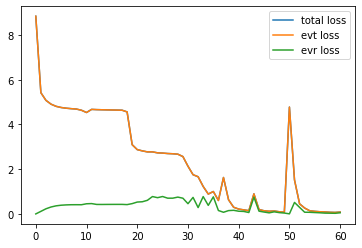

In [85]:
# training model
train_epocs(drsa, optimizer, train_dl, valid_dl, alpha=1.0, epochs=61, print_every=5)

**Training notes**:
* Seems to be very touchy with dropout. Even applying a little bit on the linear layer makes it very difficult to learn.
    - 
* batch size of 128 seems to be best
* adding more layers inside of the lstm cell seems to help
    - big jump when I went from 2-5 layers

In [86]:
# loading up saved model
# load_model(drsa, f"../models/06-17-20_DRSA_2017_2018_2019_loss_1.7337.pth")
drsa.eval()

# organizing val preds in df
valid_features = np.concatenate(padded_test_starts, axis=0)
preds = []
for X_valid, y_valid in valid_dl:
    pred = drsa(X_valid).squeeze(0).detach().numpy().reshape(-1, 1)
    preds.append(pred)
preds = np.concatenate(preds, axis=0)
valid_df = pd.DataFrame(np.hstack([valid_features, preds]), columns=cols+["last_batter", "pred"])
    
# organizing train preds in df
train_features = np.concatenate(padded_train_starts, axis=0)
preds = []
for X_train, y_train in train_dl:
    pred = drsa(X_train).squeeze(0).detach().numpy().reshape(-1, 1)
    preds.append(pred)
preds = np.concatenate(preds, axis=0)
train_df = pd.DataFrame(np.hstack([train_features, preds]), columns=cols+["last_batter", "pred"])

In [87]:
# valid_df.iloc[:50, :]

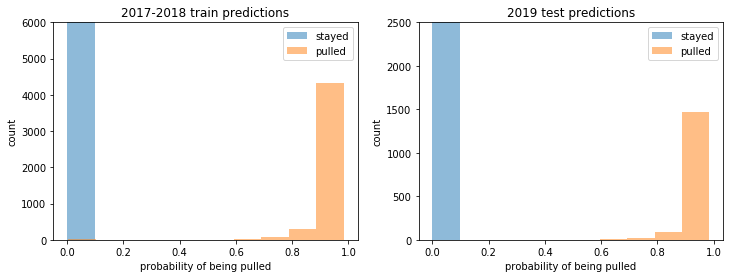

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
preds_histogram(train_df["last_batter"], train_df["pred"], ax=ax[0], ylim = (0, 6000), title="2017-2018 train predictions")
preds_histogram(valid_df["last_batter"], valid_df["pred"], ax=ax[1], ylim=(0, 2500), title="2019 test predictions")

In [89]:
# saving model
save_model(drsa, f"../models/06-17-20_DRSA_2017_2018_2019_loss_0.084.pth")

## model evaluation

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56140
         1.0       1.00      1.00      1.00      1604

    accuracy                           1.00     57744
   macro avg       1.00      1.00      1.00     57744
weighted avg       1.00      1.00      1.00     57744

mean plate appearance diff: 0.00499
mean target diff: 0.00095


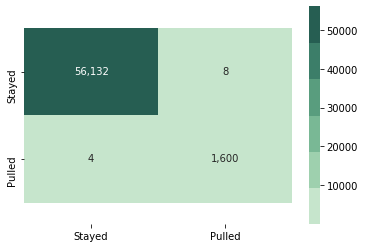

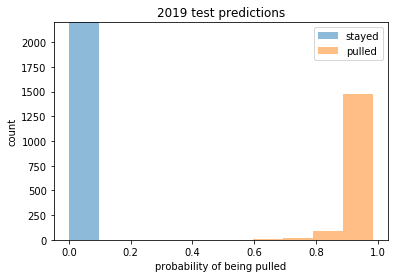

In [90]:
print_all_metrics(valid_df["last_batter"], valid_df["pred"], thresh=0.5)